# **PointNet** : **Deep Learning on 3D Point clouds**

## Problem Statement
Download the ModelNet10 dataset from the below link: http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip
This dataset has objects from 10 categories where each object is represented by a 3D Point Cloud. Design and implement a neural network architecture to solve the problem of object classification for these categories.
 In the report, include the architecture of your neural network, loss function definition, validation loss and training loss vs the epochs plot, test accuracy, and training accuracy.

In [1]:
import numpy as np
import math
import random
import os
import torch
from glob import glob
import scipy.spatial.distance
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import plotly.graph_objects as go

In [2]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA device:", torch.cuda.get_device_name(device))
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU instead.")

Using CUDA device: NVIDIA GeForce RTX 3080 Ti Laptop GPU


In [3]:
from path import Path
import trimesh


In [4]:
if torch.cuda.is_available():
  if_cuda=True
else:
  if_cuda=False
seed_value=0
np.random.seed(seed_value) # cpu vars
torch.manual_seed(seed_value) # cpu  vars
random.seed(seed_value) # Python
os.environ['PYTHONHASHSEED']=str(seed_value)
if if_cuda:
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value) # gpu vars
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [5]:
from path import Path
import trimesh
path = Path("ModelNet10")
folders = [dir for dir in sorted(os.listdir(path)) if os.path.isdir(path/dir)]
classes = {folder: i for i, folder in enumerate(folders)};
classes

{'bathtub': 0,
 'bed': 1,
 'chair': 2,
 'desk': 3,
 'dresser': 4,
 'monitor': 5,
 'night_stand': 6,
 'sofa': 7,
 'table': 8,
 'toilet': 9}

## **Visualizing mesh**

In [6]:
pcd = trimesh.load("ModelNet10/sofa/train/sofa_0002.off")
scene = trimesh.scene.Scene()
scene.add_geometry(pcd)
scene.show()

In [8]:
verts = pcd.vertices
faces = pcd.faces
print(len(verts))
print("Vertices:\n", verts[:5]) # set of points in 3D space
print("Faces:\n", faces[:5])  # set of vertex indices triplets

5630
Vertices:
 [[32.98545 -8.56285 39.55135]
 [29.8576  13.25175 10.96485]
 [32.0856  10.60875 29.60695]
 [29.0094  -5.34145 20.65725]
 [17.2913  23.47475  8.49945]]
Faces:
 [[0 1 2]
 [0 3 1]
 [2 4 5]
 [4 2 1]
 [0 2 6]]


In [9]:
v = trimesh.points.PointCloud(verts, colors=np.tile(np.array([0, 0, 0, 1]), (len(verts), 1)))
scene = trimesh.scene.Scene()
scene.add_geometry(v)
scene.show()

## **3D Data pre-processing**

### **1. Sampling points on surface**

In [10]:
# Surface point sampler using Trimesh

class PointSampler_Trimesh(object):
    def __init__(self, output_size):
        assert isinstance(output_size, int)
        self.output_size = output_size

    def __call__(self, mesh):
        sampled_pc = trimesh.sample.sample_surface(mesh,self.output_size) #does some extra reduction step if two points are really close
        pc = sampled_pc[0]
        return pc

In [11]:
pointcloud = PointSampler_Trimesh(40000)(pcd)
p = trimesh.points.PointCloud(pointcloud, colors=np.tile(np.array([0, 0, 0, 1]), (len(pointcloud), 1)))
scene = trimesh.scene.Scene()
scene.add_geometry(p)
scene.show()

In [12]:
# Writing our own surface point sampler

class PointSampler(object):
    def __init__(self, output_size):
        assert isinstance(output_size, int)
        self.output_size = output_size

    def triangle_area(self, pt1, pt2, pt3):
        side_a = np.linalg.norm(pt1 - pt2)
        side_b = np.linalg.norm(pt2 - pt3)
        side_c = np.linalg.norm(pt3 - pt1)
        s = 0.5 * ( side_a + side_b + side_c)
        return max(s * (s - side_a) * (s - side_b) * (s - side_c), 0)**0.5

    def sample_point(self, pt1, pt2, pt3):
        s, t = sorted([random.random(), random.random()])
        f = lambda i: s * pt1[i] + (t-s)*pt2[i] + (1-t)*pt3[i]
        return (f(0), f(1), f(2))


    def __call__(self, mesh):
        verts, faces = mesh
        verts = np.array(verts)
        areas = np.zeros((len(faces)))

        for i in range(len(areas)):
            areas[i] = (self.triangle_area(verts[faces[i][0]],
                                           verts[faces[i][1]],
                                           verts[faces[i][2]]))

        sampled_faces = (random.choices(faces,
                                      weights=areas,    # To sample more points from a larger triangle
                                      cum_weights=None,
                                      k=self.output_size))

        sampled_points = np.zeros((self.output_size, 3))

        for i in range(len(sampled_faces)):
            sampled_points[i] = (self.sample_point(verts[sampled_faces[i][0]],
                                                   verts[sampled_faces[i][1]],
                                                   verts[sampled_faces[i][2]]))

        return sampled_points


In [13]:
pointcloud = PointSampler(40000)((verts, faces))
p = trimesh.points.PointCloud(pointcloud, colors=np.tile(np.array([0, 0, 0, 1]), (len(pointcloud), 1)))
scene = trimesh.scene.Scene()
scene.add_geometry(p)
scene.show(line_settings={'point_size': 100})

## **2. Sampling from a set of points**
### **Random point sampling**

In [14]:
def random_point_sample(points, npoint):
  indexes = random.sample(range(points.shape[0]), npoint)
  return points[indexes]

In [15]:
randomp = random_point_sample(p.vertices, 2048)
sp = trimesh.points.PointCloud(randomp, colors=np.tile(np.array([0, 0, 0, 1]), (len(randomp), 1)))
scene = trimesh.scene.Scene()
scene.add_geometry(sp)
scene.show()

### **Farthest Point Sampling (FPS)**

In [16]:
def farthest_point_sample(points, npoint):
    """
    Input:
        point: xyz points
        npoint: number of samples
    Return:
        centroids: sampled pointcloud [npoint, D]
    """
    N, D = points.shape
    xyz = points[:,:3]
    centroids = np.zeros((npoint,))
    distance = np.ones((N,)) * 1e10
    farthest = np.random.randint(0, N)  # start with a random point
    for i in range(npoint):
        centroids[i] = farthest
        centroid = xyz[farthest, :]
        dist = np.sum((xyz - centroid) ** 2, -1)  # calculate distance of centroid with all the points
        mask = dist < distance                    # mask out already sampled points
        distance[mask] = dist[mask]
        farthest = np.argmax(distance, -1)        # get farthest point index
    points = points[centroids.astype(np.int32)]
    return points

In [17]:
sampledp = farthest_point_sample(p.vertices, 2048)
sp = trimesh.points.PointCloud(sampledp, colors=np.tile(np.array([0, 0, 0, 1]), (len(sampledp), 1)))
scene = trimesh.scene.Scene()
scene.add_geometry(sp)
scene.show()

## **Normalizing**

**Bring the mean of the point cloud to the origin (0,0,0) and scale the point cloud size to fit in a unit sphere.**

In [18]:
class Normalize(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        norm_pointcloud = pointcloud - np.mean(pointcloud, axis=0)
        norm_pointcloud /= np.max(np.linalg.norm(norm_pointcloud, axis=1))

        return  norm_pointcloud

In [19]:
norm_pointcloud = Normalize()(sampledp)

## **Data Augmentations**
**We randomly rotate the point cloud and add random noise.**

In [20]:
class RandRotation_z(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        theta = random.random() * 2. * math.pi
        rot_matrix = np.array([[ math.cos(theta), -math.sin(theta),    0],
                               [ math.sin(theta),  math.cos(theta),    0],
                               [0,                             0,      1]])

        rot_pointcloud = rot_matrix.dot(pointcloud.T).T
        return  rot_pointcloud

class RandomNoise(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        noise = np.random.normal(0, 0.02, (pointcloud.shape))

        noisy_pointcloud = pointcloud + noise
        return  noisy_pointcloud

In [21]:
rot_pointcloud = RandRotation_z()(norm_pointcloud)
noisy_rot_pointcloud = RandomNoise()(rot_pointcloud)

In [22]:
p = trimesh.points.PointCloud(noisy_rot_pointcloud, colors=np.tile(np.array([0, 0, 0, 1]), (len(noisy_rot_pointcloud), 1)))

scene = trimesh.scene.Scene()
scene.add_geometry(p)
scene.show()

In [23]:
class ToTensor(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        return torch.from_numpy(pointcloud)
    
def default_transforms():
    return transforms.Compose([
                                PointSampler_Trimesh(1024),
                                Normalize(),
                                ToTensor()
                              ])    

## **Modelnet10 Dataloader**

In [24]:
class PointCloudData(Dataset):
    def __init__(self, root_dir, valid=False, folder="train", transform=default_transforms()):
        self.root_dir = root_dir
        folders = [dir for dir in sorted(os.listdir(root_dir)) if os.path.isdir(root_dir/dir)]
        self.classes = {folder: i for i, folder in enumerate(folders)}
        self.transforms = transform if not valid else default_transforms()
        self.valid = valid
        self.files = []
        for category in self.classes.keys():
            new_dir = root_dir/Path(category)/folder
            for file in os.listdir(new_dir):
                if file.endswith('.off'):
                    sample = {}
                    sample['pcd_path'] = new_dir/file
                    sample['category'] = category
                    self.files.append(sample)

    def __len__(self):
        return len(self.files)

    def __preproc__(self, file):
        pcd = trimesh.load(file)
        verts = pcd.vertices
        faces = pcd.faces

        if self.transforms:
            pointcloud = self.transforms((pcd))
        return pointcloud

    def __getitem__(self, idx):
        pcd_path = self.files[idx]['pcd_path']
        category = self.files[idx]['category']

        pointcloud = self.__preproc__(pcd_path)

        return {'pointcloud': pointcloud,
                'category': self.classes[category]}

In [25]:
train_transforms = transforms.Compose([
                    PointSampler_Trimesh(1024),
                    Normalize(),
                    RandRotation_z(),
                    RandomNoise(),
                    ToTensor()
                    ])
train_ds = PointCloudData(path, transform=train_transforms)
valid_ds = PointCloudData(path, valid=True, folder='test')

In [26]:
inverse_classes = {i: cat for cat, i in train_ds.classes.items()};
inverse_classes

{0: 'bathtub',
 1: 'bed',
 2: 'chair',
 3: 'desk',
 4: 'dresser',
 5: 'monitor',
 6: 'night_stand',
 7: 'sofa',
 8: 'table',
 9: 'toilet'}

In [ ]:
print('Train dataset size: ', len(train_ds))
print('Valid dataset size: ', len(valid_ds))
print('Number of classes: ', len(train_ds.classes))
print('Sample pointcloud shape: ', train_ds[0]['pointcloud'].size())
print('Class: ', inverse_classes[train_ds[0]['category']])

In [29]:
train_loader = DataLoader(dataset=train_ds, batch_size=32, shuffle=True,drop_last=True)
valid_loader = DataLoader(dataset=valid_ds, batch_size=64,drop_last=True)

# **PointNet Model**
**Pointnet classification and segmentation architecture.**
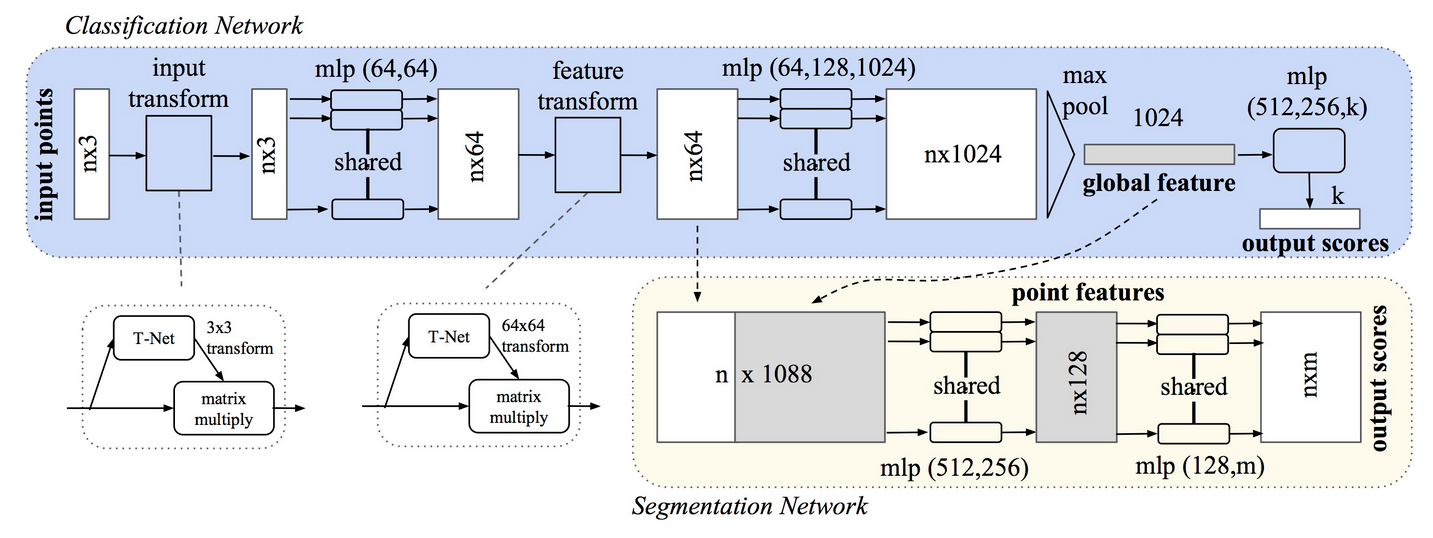

In [30]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

class Tnet(nn.Module):
   def __init__(self, k=3):
      super().__init__()
      self.k=k
      self.conv1 = nn.Conv1d(k,64,1)
      self.conv2 = nn.Conv1d(64,128,1)
      self.conv3 = nn.Conv1d(128,1024,1)
      self.fc1 = nn.Linear(1024,512)
      self.fc2 = nn.Linear(512,256)
      self.fc3 = nn.Linear(256,k*k)

      self.bn1 = nn.BatchNorm1d(64)
      self.bn2 = nn.BatchNorm1d(128)
      self.bn3 = nn.BatchNorm1d(1024)
      self.bn4 = nn.BatchNorm1d(512)
      self.bn5 = nn.BatchNorm1d(256)


   def forward(self, input):
      # input.shape == (bs,n,3)
      bs = input.size(0)
      xb = F.relu(self.bn1(self.conv1(input)))
      xb = F.relu(self.bn2(self.conv2(xb)))
      xb = F.relu(self.bn3(self.conv3(xb)))
      pool = nn.MaxPool1d(xb.size(-1))(xb)
      flat = nn.Flatten(1)(pool)
      xb = F.relu(self.bn4(self.fc1(flat)))
      xb = F.relu(self.bn5(self.fc2(xb)))

      #initialize as identity
      init = torch.eye(self.k, requires_grad=True).repeat(bs,1,1)
      if xb.is_cuda:
        init=init.cuda()
      matrix = self.fc3(xb).view(-1,self.k,self.k) + init
      return matrix


class Transform(nn.Module):
   def __init__(self):
        super().__init__()
        self.input_transform = Tnet(k=3)
        self.feature_transform = Tnet(k=64)
        self.conv1 = nn.Conv1d(3,64,1)

        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)


        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)

   def forward(self, input):
        matrix3x3 = self.input_transform(input)
        # batch matrix multiplication
        xb = torch.bmm(torch.transpose(input,1,2), matrix3x3).transpose(1,2)

        xb = F.relu(self.bn1(self.conv1(xb)))

        matrix64x64 = self.feature_transform(xb)
        xb = torch.bmm(torch.transpose(xb,1,2), matrix64x64).transpose(1,2)

        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = self.bn3(self.conv3(xb))
        xb = nn.MaxPool1d(xb.size(-1))(xb)
        output = nn.Flatten(1)(xb)
        return output, matrix3x3, matrix64x64

class PointNet(nn.Module):
    def __init__(self, classes = 10):
        super().__init__()
        self.transform = Transform()
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, classes)


        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(p=0.3)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        xb, matrix3x3, matrix64x64 = self.transform(input)
        xb = F.relu(self.bn1(self.fc1(xb)))
        xb = F.relu(self.bn2(self.dropout(self.fc2(xb))))
        output = self.fc3(xb)
        return self.logsoftmax(output), matrix3x3, matrix64x64

# **Loss**
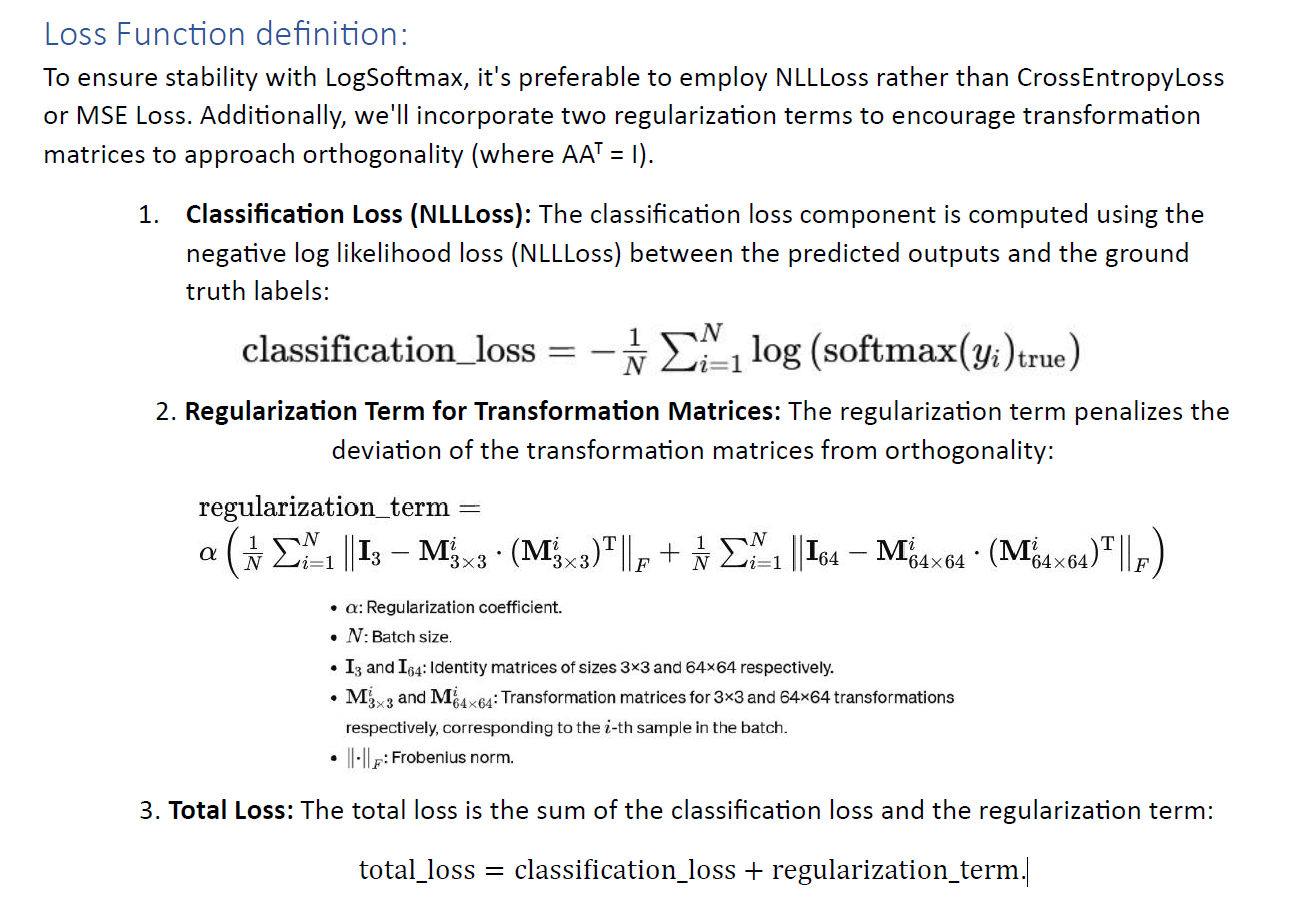


In [31]:

def pointnetloss(outputs, labels, m3x3, m64x64, alpha = 0.0001):
    criterion = torch.nn.NLLLoss()  # Classification loss

    bs=outputs.size(0)
    id3x3 = torch.eye(3, requires_grad=True).repeat(bs,1,1)
    id64x64 = torch.eye(64, requires_grad=True).repeat(bs,1,1)
    if outputs.is_cuda:
        id3x3=id3x3.cuda()
        id64x64=id64x64.cuda()
    diff3x3 = id3x3-torch.bmm(m3x3,m3x3.transpose(1,2))
    diff64x64 = id64x64-torch.bmm(m64x64,m64x64.transpose(1,2))
    return criterion(outputs, labels) + alpha * (torch.norm(diff3x3)+torch.norm(diff64x64)) / float(bs)

In [87]:
import gc
torch.cuda.empty_cache()
gc.collect()

0

In [88]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [89]:
pointnet = PointNet()
pointnet.to(device);
optimizer = torch.optim.Adam(pointnet.parameters(), lr=0.00025)

In [90]:
def train(model, train_loader, val_loader=None, epochs=15, save=True):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = total = 0  # Initialize counters for accuracy calculation

        for i, data in enumerate(train_loader, 0):
            inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
            optimizer.zero_grad()
            outputs, m3x3, m64x64 = model(inputs.transpose(1, 2))

            loss = pointnetloss(outputs, labels, m3x3, m64x64)
            loss.backward()
            optimizer.step()

            # Accumulate loss for printing
            running_loss += loss.item()
            #if i % 5 == 4:  # print every 5 mini-batches
            #    print('[Epoch: %d, Batch: %4d / %4d], training loss: %.3f' %
            #          (epoch + 1, i + 1, len(train_loader), running_loss / 10))
            #    running_loss = 0.0
                
            if i % 5 == 4:  # print every 5 mini-batches
                print('[Epoch: %d, Batch: %4d / %4d], training loss: %.3f' %
                      (epoch + 1, i + 1, len(train_loader), running_loss / (i + 1)))            

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_losses.append(running_loss / len(train_loader))
        train_accuracy = 100. * correct / total
        train_accuracies.append(train_accuracy)

        # Validation
        if val_loader:
            model.eval()
            val_loss = 0.0
            correct = total = 0

            with torch.no_grad():
                for data in val_loader:
                    inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
                    outputs, m3x3, m64x64 = model(inputs.transpose(1,2))
                    loss = pointnetloss(outputs, labels, m3x3, m64x64)
                    val_loss += loss.item()

                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            val_losses.append(val_loss / len(val_loader))
            val_accuracy = 100. * correct / total
            val_accuracies.append(val_accuracy)
            print('Epoch %d: Validation Loss: %.3f, Validation Accuracy: %.2f %%' %
                  (epoch + 1, val_loss / len(val_loader), val_accuracy))

        # save the model
        if save:
            torch.save(model.state_dict(), "save_a2_"+str(epoch)+".pth")

        print(f'Epoch {epoch + 1}: Training Accuracy: {train_accuracy:.2f} %')
        
    return train_losses, val_losses, train_accuracies, val_accuracies


In [91]:
train_losses, val_losses, train_accuracies, val_accuracies = train(pointnet, train_loader, valid_loader, 8, save=True)

[Epoch: 1, Batch:    5 /  124], training loss: 2.287
[Epoch: 1, Batch:   10 /  124], training loss: 2.089
[Epoch: 1, Batch:   15 /  124], training loss: 2.019
[Epoch: 1, Batch:   20 /  124], training loss: 1.891
[Epoch: 1, Batch:   25 /  124], training loss: 1.826
[Epoch: 1, Batch:   30 /  124], training loss: 1.738
[Epoch: 1, Batch:   35 /  124], training loss: 1.664
[Epoch: 1, Batch:   40 /  124], training loss: 1.599
[Epoch: 1, Batch:   45 /  124], training loss: 1.546
[Epoch: 1, Batch:   50 /  124], training loss: 1.502
[Epoch: 1, Batch:   55 /  124], training loss: 1.457
[Epoch: 1, Batch:   60 /  124], training loss: 1.420
[Epoch: 1, Batch:   65 /  124], training loss: 1.398
[Epoch: 1, Batch:   70 /  124], training loss: 1.366
[Epoch: 1, Batch:   75 /  124], training loss: 1.344
[Epoch: 1, Batch:   80 /  124], training loss: 1.318
[Epoch: 1, Batch:   85 /  124], training loss: 1.302
[Epoch: 1, Batch:   90 /  124], training loss: 1.282
[Epoch: 1, Batch:   95 /  124], training loss:

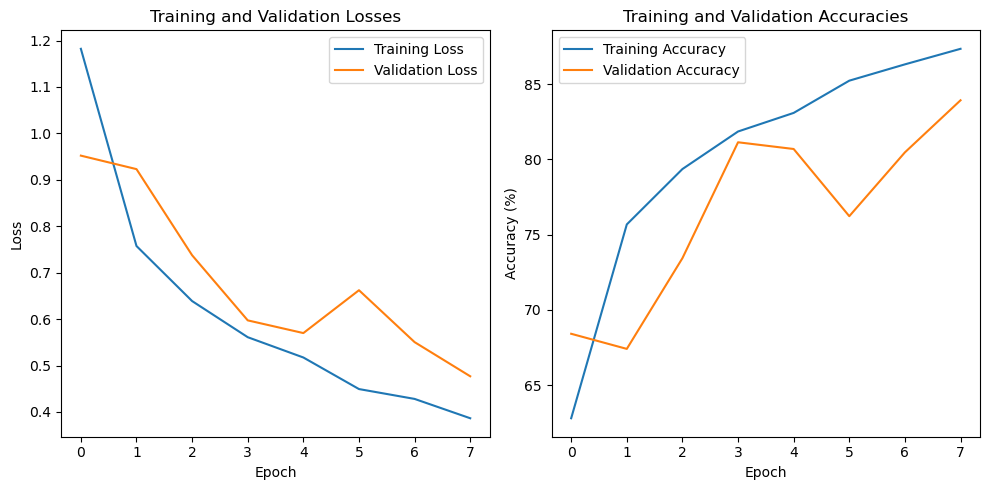

In [92]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
if val_loader:
    plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
if val_loader:
    plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracies')
plt.legend()

plt.tight_layout()
plt.show()     

#### model save_a2_7.pth has been saved - it has 83+% accuracy in validation data
#### **it is renamed as model_acc83.pth**

In [94]:
from sklearn.metrics import confusion_matrix

pointnet = PointNet()
pointnet.load_state_dict(torch.load('model_acc83.pth',map_location=torch.device('cpu')))
pointnet.eval();

pointnet.eval();
all_preds = []
all_labels = []
with torch.no_grad():
    for i, data in enumerate(valid_loader):
        print('Batch [%4d / %4d]' % (i+1, len(valid_loader)))

        inputs, labels = data['pointcloud'].float(), data['category']
        outputs, __, __ = pointnet(inputs.transpose(1,2))
        _, preds = torch.max(outputs.data, 1)
        all_preds += list(preds.numpy())
        all_labels += list(labels.numpy())

# Convert lists to numpy arrays if necessary
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

Batch [   1 /   14]
Batch [   2 /   14]
Batch [   3 /   14]
Batch [   4 /   14]
Batch [   5 /   14]
Batch [   6 /   14]
Batch [   7 /   14]
Batch [   8 /   14]
Batch [   9 /   14]
Batch [  10 /   14]
Batch [  11 /   14]
Batch [  12 /   14]
Batch [  13 /   14]
Batch [  14 /   14]


In [95]:
cm = confusion_matrix(all_labels, all_preds);
cm

array([[41,  2,  0,  0,  0,  1,  0,  6,  0,  0],
       [ 2, 79,  1,  1,  0,  1,  0, 15,  0,  1],
       [ 0,  0, 99,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  2, 57,  1,  2,  1,  2, 19,  1],
       [ 0,  0,  0,  9, 61,  5, 10,  0,  1,  0],
       [ 0,  1,  1,  0,  1, 95,  1,  0,  0,  1],
       [ 0,  0,  1,  5, 16,  3, 58,  0,  3,  0],
       [ 1,  1,  0,  7,  0,  3,  1, 86,  0,  1],
       [ 0,  0,  0, 15,  0,  0,  0,  0, 85,  0],
       [ 0,  0,  1,  0,  0,  3,  0,  0,  0, 84]], dtype=int64)

In [96]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

# function from https://deeplizard.com/learn/video/0LhiS6yu2qQ
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


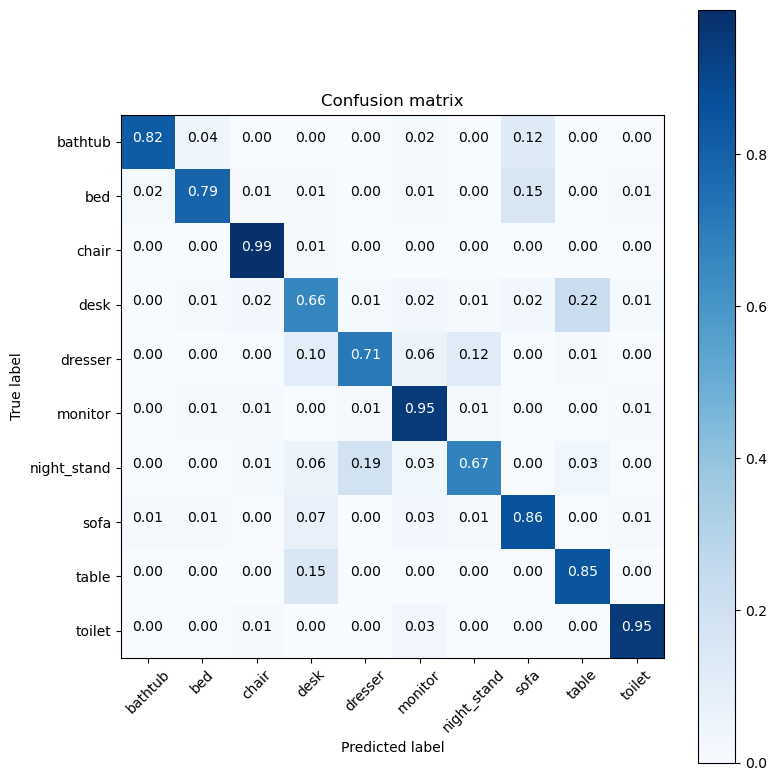

In [97]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, list(classes.keys()), normalize=True)

Confusion matrix, without normalization


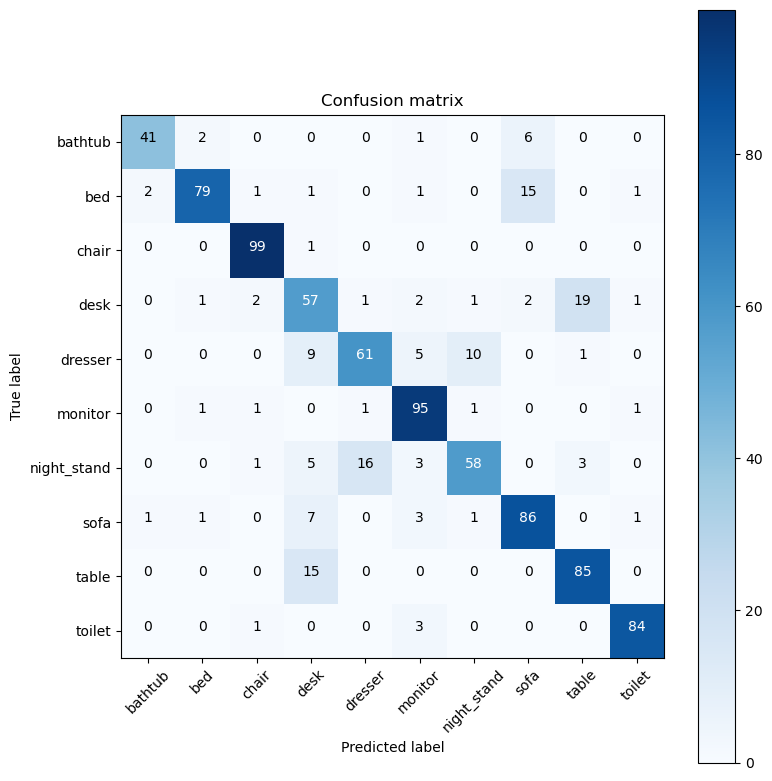

In [98]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, list(classes.keys()), normalize=False)

In [99]:
test_ds = PointCloudData(path, valid=True, folder='test')
test_loader = DataLoader(dataset=test_ds, batch_size=64,drop_last=True)

pointnet.eval()
all_preds = []
all_labels = []
all_pointclouds = []  # To store the point clouds for visualization

with torch.no_grad():
    for i, data in enumerate(test_loader):
        print('Batch [%4d / %4d]' % (i+1, len(test_loader)))
      
        inputs, labels = data['pointcloud'].float(), data['category']
        outputs, __, __ = pointnet(inputs.transpose(1,2))
        _, preds = torch.max(outputs.data, 1)

        #all_preds.extend(preds.numpy())
        #all_labels.extend(labels.numpy())
        #all_pointclouds.extend(inputs.numpy())  # Storing the input point clouds
        all_preds += list(preds.numpy())
        all_labels += list(labels.numpy())     
        all_pointclouds+=list(inputs.numpy())

# Convert lists to numpy arrays if necessary
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_pointclouds = np.array(all_pointclouds)

# Sample 10 random indices from the predictions
num_samples = 10
indices = np.random.choice(len(all_preds), num_samples, replace=False)

# Select the samples using the random indices
sampled_pointclouds = all_pointclouds[indices]
sampled_preds = all_preds[indices]
sampled_labels = all_labels[indices]

Batch [   1 /   14]
Batch [   2 /   14]
Batch [   3 /   14]
Batch [   4 /   14]
Batch [   5 /   14]
Batch [   6 /   14]
Batch [   7 /   14]
Batch [   8 /   14]
Batch [   9 /   14]
Batch [  10 /   14]
Batch [  11 /   14]
Batch [  12 /   14]
Batch [  13 /   14]
Batch [  14 /   14]


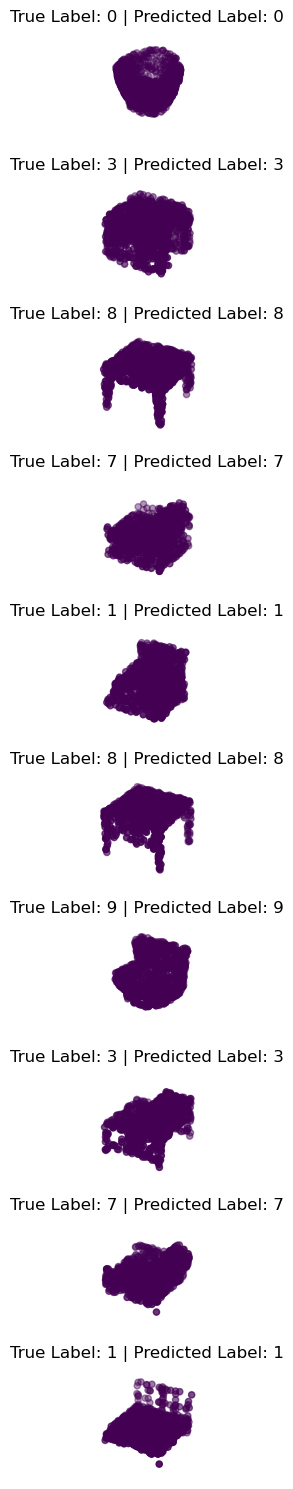

In [100]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def visualize_predictions(point_clouds, labels, preds, num_samples=10):
    fig = plt.figure(figsize=(15, num_samples * 1.5))

    for i in range(min(num_samples, len(point_clouds))):
        ax = fig.add_subplot(num_samples, 1, i + 1, projection='3d')
        color_map = np.full(shape=point_clouds[i].shape[0], fill_value=preds[i], dtype=int)  # Create a color array

        ax.scatter(point_clouds[i][:, 0], point_clouds[i][:, 1], point_clouds[i][:, 2], c=color_map, cmap='viridis', marker='o')
        
        ax.set_title('True Label: {} | Predicted Label: {}'.format(labels[i], preds[i]))
        ax.set_axis_off()

    plt.tight_layout()
    plt.show()

# Assuming point_clouds, labels, and preds are already loaded as shown previously

# Use the visualization function
visualize_predictions(sampled_pointclouds, sampled_labels, sampled_preds)


In [101]:
import torch.nn as nn

def print_model_architecture(model):
    print(model)
    print('\nModel Architecture:')
    print('===================')
    for name, layer in model.named_children():
        print(f'Layer Name: {name}')
        print(layer)
        print('-------------------')

# Example usage:
# Assuming you have a PyTorch model named "my_model"
# Replace "my_model" with the name of your actual model

# print the architecture of the model
print_model_architecture(pointnet)


PointNet(
  (transform): Transform(
    (input_transform): Tnet(
      (conv1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
      (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (conv3): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
      (fc1): Linear(in_features=1024, out_features=512, bias=True)
      (fc2): Linear(in_features=512, out_features=256, bias=True)
      (fc3): Linear(in_features=256, out_features=9, bias=True)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (feature_transform): Tnet(
      (conv1): Conv1d(64, 64, kernel_size=(1,